In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER



class Model(object):
    def __init__(self, Nmodes, rho, L, index_type):
        self.Nmodes = Nmodes
        self.rho = rho
        self.L = L
        self.index_type = index_type
        self.features = NonlienarFeatures(Nmodes=self.Nmodes, rho=self.rho, L = self.L, index_type=self.index_type)
        self.C = torch.zeros(len(self.features.index), dtype=torch.complex64)

    def scatter(self, figsize=(10,10),dpi=400, s=3):
        x,y = zip(*self.features.index)
        values = np.log10(np.abs(self.C) + 1e-8)
        plt.figure(figsize=figsize, dpi=dpi)
        FoPBC(rho=self.rho, L=self.L, Nmodes=self.Nmodes, index_type=self.index_type).scatter_C(x,y,values, s=s)
        return 

    def scale(self, train_p, test_p):
        return 10**(test_p/10) / 10**(train_p/10)
    
    def fit(self, train_signal, train_truth, train_z, truncation=[0,-1], lamb_l2=0.1):
        s,e = truncation
        E = train_signal.val
        X = torch.squeeze(self.features(E, E, E))[s:e]
        Y = torch.squeeze(train_signal.val - train_truth.val)[s:e]
        A = (X.T.conj() @ X) / X.shape[0] + lamb_l2 * torch.eye(X.shape[1])               # A.eig: 4e5 ~ 1e8
        b = (X.T.conj()) @ Y /X.shape[0]
        self.C = torch.linalg.solve(A, b)
        print('Model fit complete!')
        return 
    
    def get_pbc(self, test_signal, train_p, test_p):
        PBC = (torch.squeeze(self.features(test_signal.val, test_signal.val, test_signal.val)) @ self.C ) * self.scale(train_p, test_p)
        return PBC


    def predict(self, test_signal, train_p, test_p, xi=1):
        return test_signal.val[0,:,0] - xi*self.get_pbc(test_signal, train_p, test_p)

    def test(self, test_signal, truth_signal, train_p, test_p, xi=1, BER_discard=10000):
        Yhat_test = self.predict(test_signal, train_p, test_p, xi=xi)
        return BER(Yhat_test[BER_discard: - BER_discard,None], truth_signal.val[0,BER_discard:-BER_discard])


BER_discard = 10000

# data

In [28]:
np.block([np.ones(10), np.zeros(10)])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [8]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER


# fit function
def fit(A, y, lamb_l2=0, SO=False):
    # if type(A) != np.ndarray:
    #     A = np.array(A)
    #     y = np.array(y)
    # if SO:
    #     N = A.shape[1]//2
    #     K = np.diag(np.block([np.zeros(N), np.ones( A.shape[1] - N)]))
    # else:
    #     K = np.eye(A.shape[1])
    K = torch.eye(A.shape[1])
    A_ = (A.T.conj() @ A) / A.shape[0] + lamb_l2 * K        
    b = (A.T.conj()) @ y /A.shape[0]
    return np.linalg.solve(A_, b)

def fit_selection(A, y, lamb_l2=0):
    idx = np.arange(A.shape[1])

    for i in range(2):
        A_ = A[:,idx]
        x = fit(A_, y, lamb_l2)
        xabs = np.abs(x)
        mask = (xabs >= np.median(xabs))
        idx = idx[np.arange(len(xabs))[mask==1]]
        print(i, len(idx))
    A_ = A[:,idx]
    x = fit(A_, y, lamb_l2)
    return idx, x


def fit_ridge(A, y, lamb_l2=0):
    if type(A) != np.ndarray:
        A = np.array(A)
        y = np.array(y)
    A_ = np.block([[A.real, -A.imag], [A.imag, A.real]])
    y_ = np.block([y.real,y.imag])
    N = A.shape[1]
    reg = linear_model.Ridge(alpha=lamb_l2*A.shape[0])
    reg.fit(A_, y_)
    return reg.coef_[0:N] + 1j*reg.coef_[N:2*N]
    
def fit_lasso(A, y, alpha):
    if type(A) != np.ndarray:
        A = np.array(A)
        y = np.array(y)
    A_ = np.block([[A.real, -A.imag], [A.imag, A.real]])
    y_ = np.block([y.real,y.imag])
    N = A.shape[1]
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(A_, y_)
    return reg.coef_[0:N] + 1j*reg.coef_[N:2*N]


def test(xis, X_train, symb_train, C, power_diff, k=1, BER_discard=10000):
    pbc = X_train[:,k:] @ C
    Ls = []
    Qs = []

    for xi in xis:
        Yhat0 = X_train[:,0] + xi*10**(power_diff/10)*pbc
        Ls.append(torch.mean(torch.abs(Yhat0 - symb_train)**2))
        Qs.append(BER(Yhat0[BER_discard//2:-BER_discard//2,None], symb_train[BER_discard//2:-BER_discard//2, None])['Qsq'])
    return np.array(Ls), np.array(Qs)

train_path = "data/train_data_afterCDCDSP.pkl"
test_path = "data/test_data_afterCDCDSP.pkl"


train_p = 0
test_p = -2


train_signal, train_truth, train_z = get_signals(train_path, Nch=1, Rs=40, Pch=[train_p], device='cpu')
test_signal, test_truth, test_z = get_signals(test_path, Nch=1, Rs=40, Pch=[test_p], device='cpu')
    


def test_PBC(rho, L, lamb_l2=0.01, s=2000, e=-2000, k=1, SO=False):
    '''
        s,e,k = 2000, -2000, 1            # s,e:symol start and end, k:feature start 0 or 1
        lamb_l2 = 0
    '''
    f = NonlienarFeatures(Nmodes=1, rho=rho, L = L, index_type='reduce-1')

    # FO features
    X_train = torch.cat([torch.squeeze(train_signal.val)[:, None], torch.squeeze(f(train_signal.val, train_signal.val, train_signal.val))], dim=1)
    X_test  = torch.cat([torch.squeeze(test_signal.val)[:, None], torch.squeeze(f(test_signal.val, test_signal.val, test_signal.val))], dim=1)

    # SO Features
    if SO:
        X_train1 = (X_train[:, 0]**2)[:,None] * X_train[:, 1:]
        X_test1 = (X_test[:, 0]**2)[:,None] * X_test[:, 1:]

        X_train = torch.cat([X_train, X_train1], dim=1)
        X_test = torch.cat([X_test, X_test1], dim=1)

    Y_train = torch.squeeze(train_truth.val - train_signal.val)
    Y_test = torch.squeeze(test_truth.val - test_signal.val)
    symb_train = torch.squeeze(train_truth.val)
    symb_test = torch.squeeze(test_truth.val)

    C = fit(X_train[s:e,k:], Y_train[s:e], lamb_l2=lamb_l2, SO=SO)
    # C = fit_ridge(X_train[s:e,k:], Y_train[s:e], lamb_l2=lamb_l2)
    # C = fit_lasso(X_train[s:e,k:], Y_train[s:e], alpha=lamb_l2)

    xis = np.linspace(0.6, 1.5, 100)
    Ls, Qs = test(xis, X_test, symb_test, C, power_diff=test_p-train_p, k=k)
    Q1 = test([1], X_test, symb_test, C, power_diff=test_p-train_p, k=k)[1][0,0]

    return np.max(Qs), Q1, xis[np.argmax(Qs)], C
# Ls_ = (Ls - np.mean(Ls)) / np.std(Ls)
# Qs_ = (Qs - np.mean(Qs)) / np.std(Qs)

# plt.plot(xis, -Ls_)
# plt.plot(xis, Qs_)
# print('best xi for Q factor', xis[np.argmax(Qs)], '   Best Q factor:', np.max(Qs),  '       xi=1 Q factor:', Q1 )
# print('best xi for Q factor', xis[np.argmin(Ls)])
# print(f'|{rho}|{L}| {train_p} | {test_p} | [{s}:{e}] | {lamb_l2} | {Q1:.2f} (xi=1)| {np.max(Qs):.2f} (xi={xis[np.argmax(Qs)]:.2f})|')

In [9]:
Qm,Q1,xi, C1 = test_PBC(1, 800,lamb_l2=0.01, s=2000, e=-2000, SO=False)
Qm, Q1, xi

(10.762385, 10.748924, 1.018181818181818)

In [12]:
Qm,Q1,xi, C1 = test_PBC(1, 900,lamb_l2=0.01, SO=False)
Qm, Q1, xi

(10.748924, 10.735685, 1.009090909090909)

In [14]:
Qm,Q1,xi, C1 = test_PBC(1, 900,lamb_l2=0.1, SO=False)
Qm, Q1, xi

(10.742277, 10.729149, 1.0636363636363635)

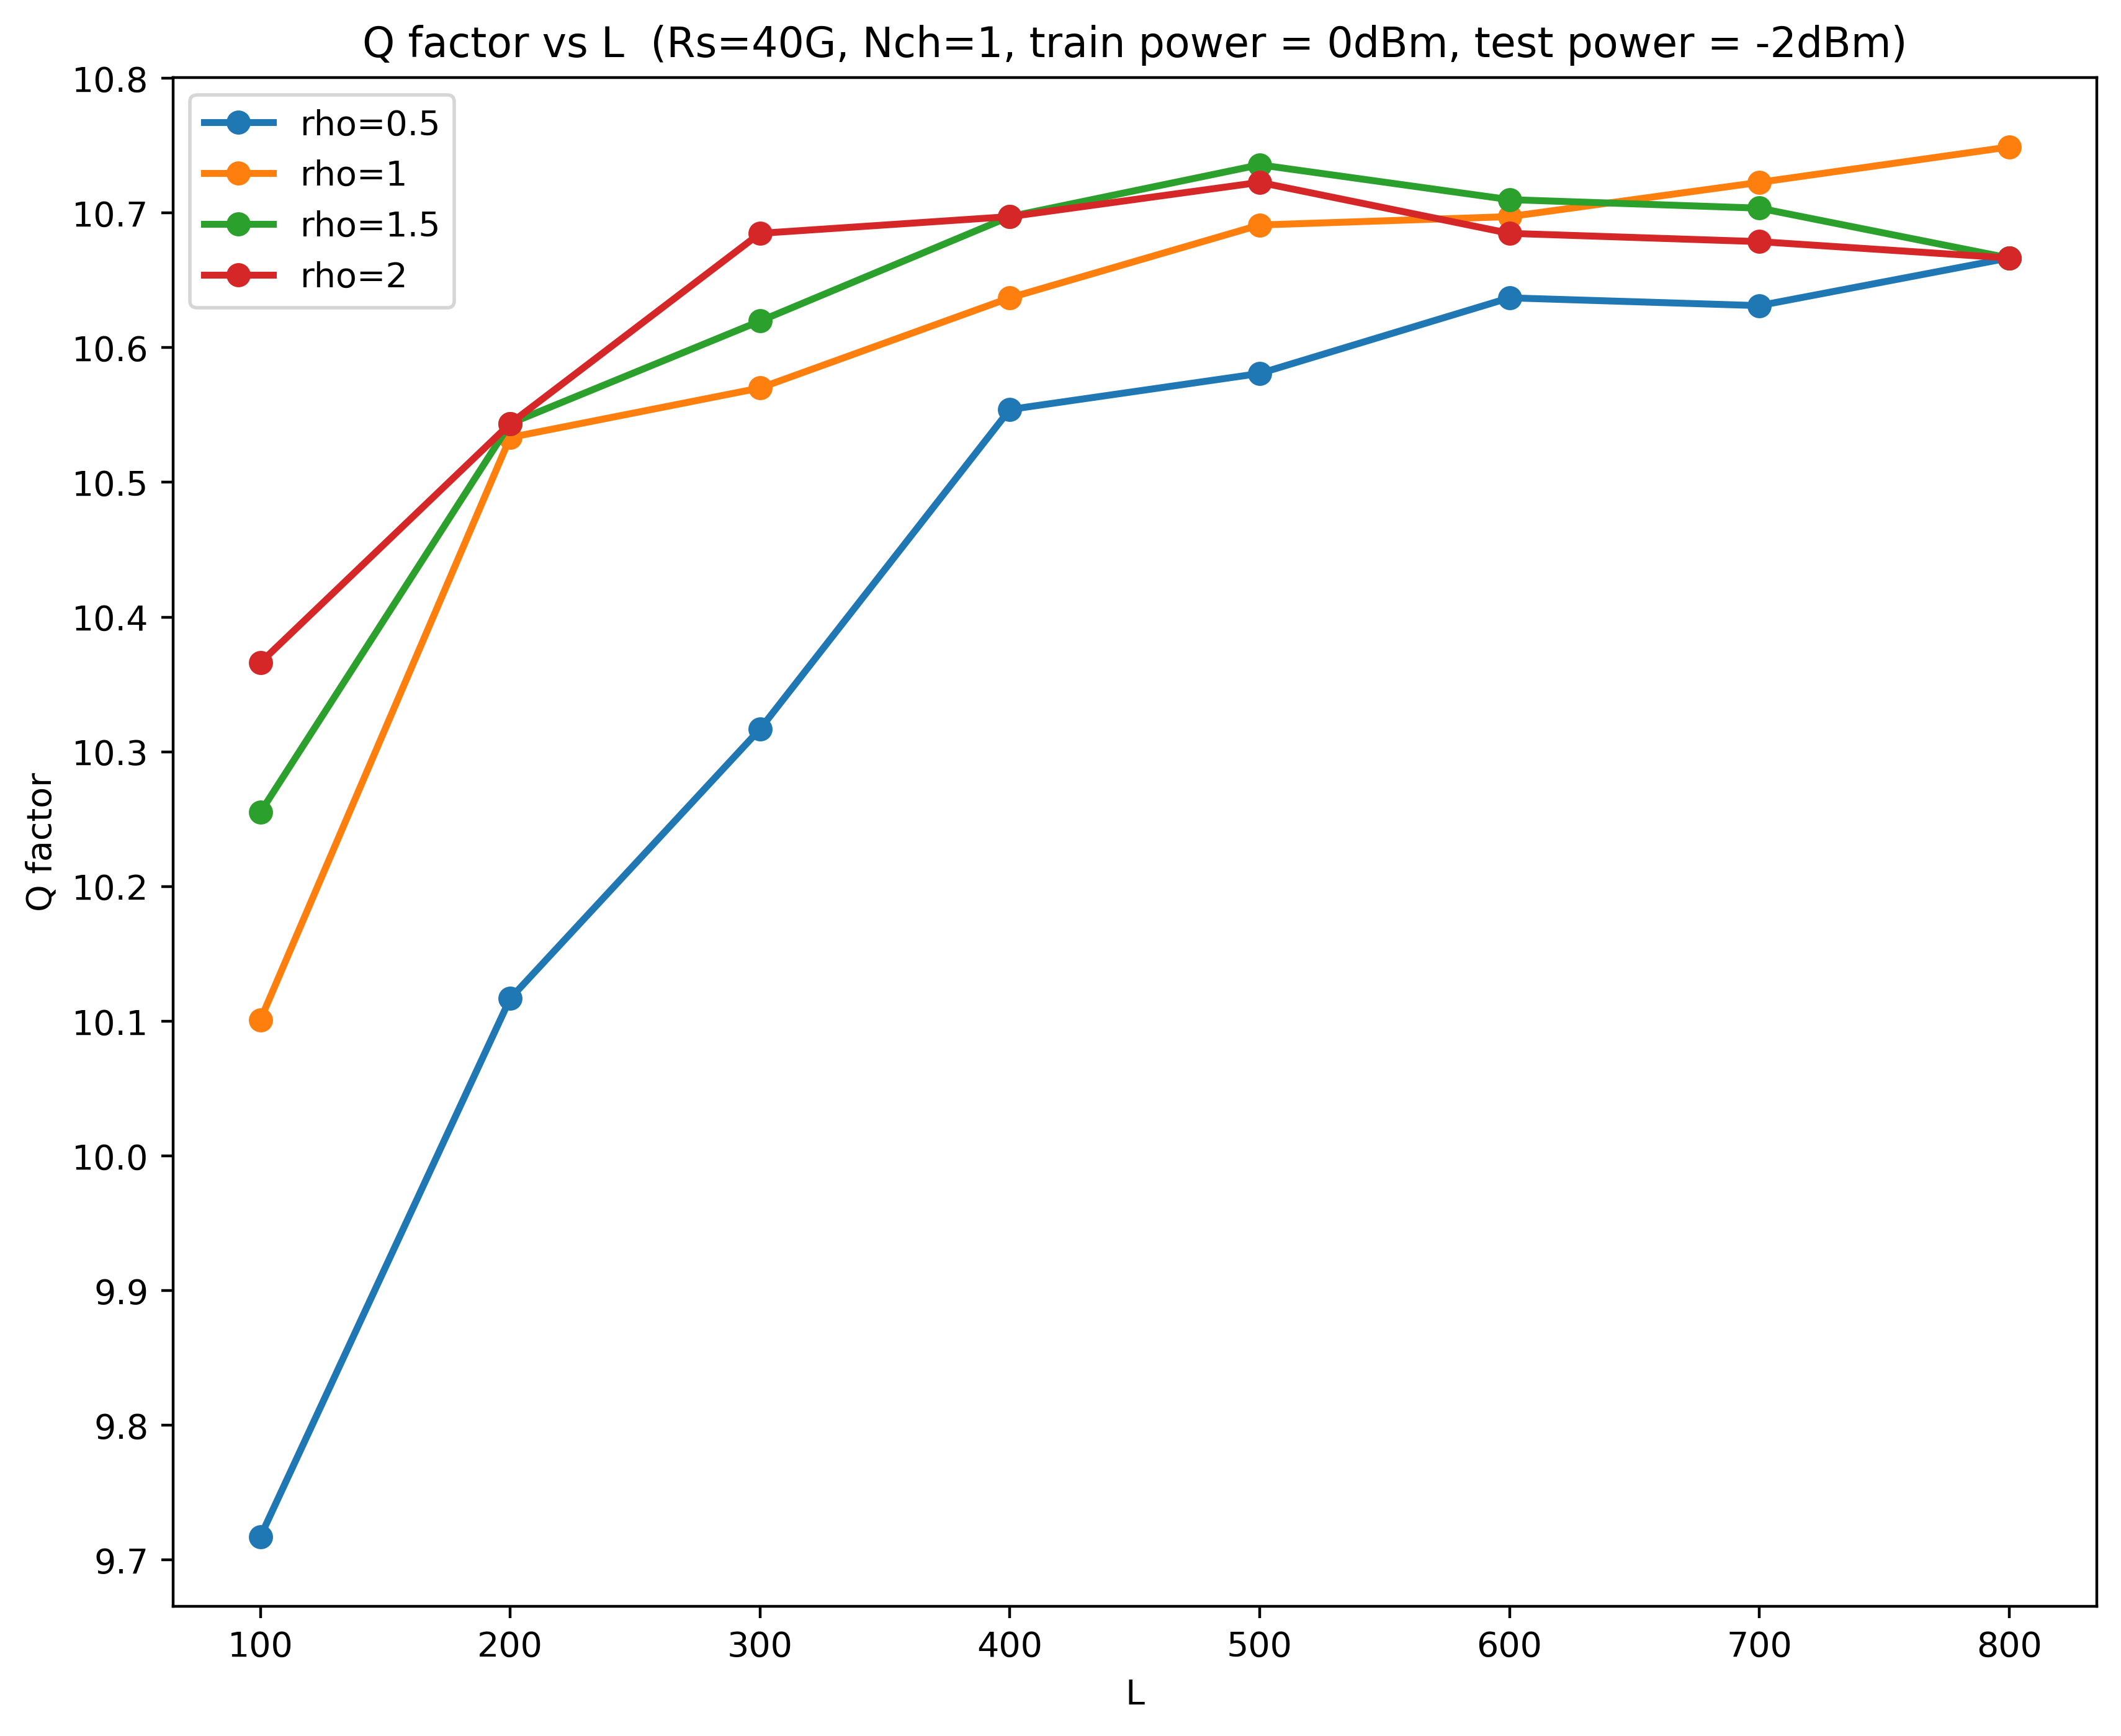

In [11]:
res = pickle.load(open('res.pkl', 'rb'))

plt.figure(figsize=(10,8), dpi=400)
Ls = [100, 200, 300, 400, 500, 600, 700, 800]
plt.plot(Ls, [res[f'Q1 rho=0.5, L={L}'] for L in Ls], '-o',linewidth=2, label='rho=0.5')
plt.plot(Ls, [res[f'Q1 rho=1, L={L}'] for L in Ls],'-o',linewidth=2,label='rho=1')
plt.plot(Ls, [res[f'Q1 rho=1.5, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=1.5')
plt.plot(Ls, [res[f'Q1 rho=2, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=2')
plt.xlabel('L')
plt.ylabel('Q factor')
plt.title('Q factor vs L  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')
plt.yticks(np.arange(9.7, 10.8, 0.1))
plt.legend()

- 40G
  
|rho|L| train power | test power | train [s,e]  |  lamb_l2 | Q           | best Q           | 
|---------|---------|---------    |---------   |---------     |--------- |---------    |--------         |
|1|400| 1 | -2 | [2000:-2000] | 0 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.05 | 10.62 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [10000:-10000] | 0.1 | 10.61 (xi=1)| 10.63 (xi=1.03)|
|1|400| 1 | -2 | [1000:-1000] | 0.1 | 10.61 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.1 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.2 | 10.58 (xi=1)| 10.65 (xi=1.07)|
|1|400| 1 | -1 | [2000:-2000] | 0 | 10.13 (xi=1)| 10.14 (xi=1.10)|
|1|400| 0 | -3 | [2000:-2000] | 0 | 10.46 (xi=1)| 10.48 (xi=0.95)|
|1|400| 0 | -3 | [2000:-2000] | 0.1 | 10.47 (xi=1)| 10.48 (xi=0.99)|
|1|400| -1 | -2 | [2000:-2000] | 0.1 | 10.60 (xi=1)| 10.62 (xi=0.94)|
|1|400| -2 | -2 | [2000:-2000] | 0.1 | 10.56 (xi=1)| 10.57 (xi=0.92)|
|1|400| -2 | -2 | [2000:-2000] | 0 | 10.52 (xi=1)| 10.58 (xi=0.95)|
|1|400| 0 | -2 | [10000:-10000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [1000:-1] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-2000] | 0 | 10.60 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0 | 10.62 (xi=1)| 10.65 (xi=0.97)|
|1|400| 0 | -2 | [10000:-10000] | 0.01 | 10.64 (xi=1)| 10.64 (xi=0.95)|
|1|400| 0 | -2 | [2000:-4000] | 0.01 | 10.64 (xi=1)| 10.65 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0.1 | 10.64 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=1.02)|
|1|400| 0 | -2 | [2000:-4000] | 0.1 | 10.67 (xi=1)| 10.67 (xi=0.94)|
|1|400| 0 | -2 | [2000:-4000] | 0.05 | 10.64 (xi=1)| 10.67 (xi=1.04)|
|1|400| 0 | -2 | [10000:-10000] | 0.05 | 10.64 (xi=1)| 10.66 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.2 | 10.65 (xi=1)| 10.67 (xi=1.03)|
|1|400| 0 | -2 | [10000:-10000] | 0.3 | 10.63 (xi=1)| 10.64 (xi=1.05)|
|1|200| 0 | -2 | [2000:-2000] | 0.1 | 10.54 (xi=1)| 10.55 (xi=1.06)|
|1|100| 0 | -2 | [2000:-2000] | 0.1 | 10.08 (xi=1)| 10.09 (xi=1.03)|
|2|100| 0 | -2 | [2000:-2000] | 0.1 | 10.39 (xi=1)| 10.40 (xi=0.97)|
|2|100| 0 | -2 | [2000:-2000] | 0 | 10.37 (xi=1)| 10.39 (xi=0.97)|

In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER

def fit(X,Y, lamb_l2:float=0):
    A = (X.T.conj() @ X) / X.shape[0] + lamb_l2 * torch.eye(X.shape[1])               # A.eig: 4e5 ~ 1e8
    b = (X.T.conj()) @ Y /X.shape[0]
    return torch.linalg.solve(A, b)

def test(xis, X_train, symb_train, C, power_diff, k=1, BER_discard=10000):
    pbc = X_train[:,k:] @ C
    Ls = []
    Qs = []

    for xi in xis:
        Yhat0 = X_train[:,0] + xi*10**(power_diff/10)*pbc
        Ls.append(torch.mean(torch.abs(Yhat0 - symb_train)**2))
        Qs.append(BER(Yhat0[BER_discard//2:-BER_discard//2,None], symb_train[BER_discard//2:-BER_discard//2, None])['Qsq'])
    return np.array(Ls), np.array(Qs)

train_path = "data/train_data_afterCDCDSP.pkl"
test_path = "data/test_data_afterCDCDSP.pkl"


train_p = 0
test_p = 0
train_signal, train_truth, train_z = get_signals(train_path, Nch=1, Rs=40, Pch=[train_p],  device='cpu')
test_signal, test_truth, test_z = get_signals(test_path, Nch=1, Rs=40, Pch=[test_p], device='cpu')

def test_PBC(rho, L, lamb_l2=0.1, s=2000, e=-2000, k=1):
    '''
        s,e,k = 2000, -2000, 1            # s,e:symol start and end, k:feature start 0 or 1
        lamb_l2 = 0
    '''
    f = NonlienarFeatures(Nmodes=1, rho=rho, L = L, index_type='reduce-1')
    X_train = torch.cat([torch.squeeze(train_signal.val)[:, None], torch.squeeze(f(train_signal.val, train_signal.val, train_signal.val))], dim=1)
    X_test  = torch.cat([torch.squeeze(test_signal.val)[:, None], torch.squeeze(f(test_signal.val, test_signal.val, test_signal.val))], dim=1)
    Y_train = torch.squeeze(train_truth.val - train_signal.val)
    Y_test = torch.squeeze(test_truth.val - test_signal.val)
    symb_train = torch.squeeze(train_truth.val)
    symb_test = torch.squeeze(test_truth.val)

    C = fit(X_train[s:e,k:], Y_train[s:e], lamb_l2=lamb_l2)

    xis = np.linspace(0.6, 1.5, 100)
    Ls, Qs = test(xis, X_test, symb_test, C, power_diff=test_p-train_p, k=k)
    Q1 = test([1], X_test, symb_test, C, power_diff=test_p-train_p, k=k)[1][0,0]

    return np.max(Qs), Q1, xis[np.argmax(Qs)], C

In [84]:
[res[f'Q1 D={d} L={L}'] for d in Ds]

[9.374218, 9.745485, 9.968502, 10.116783, 10.079033, 10.088329, 10.10087]

In [83]:
test_PBC

100

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

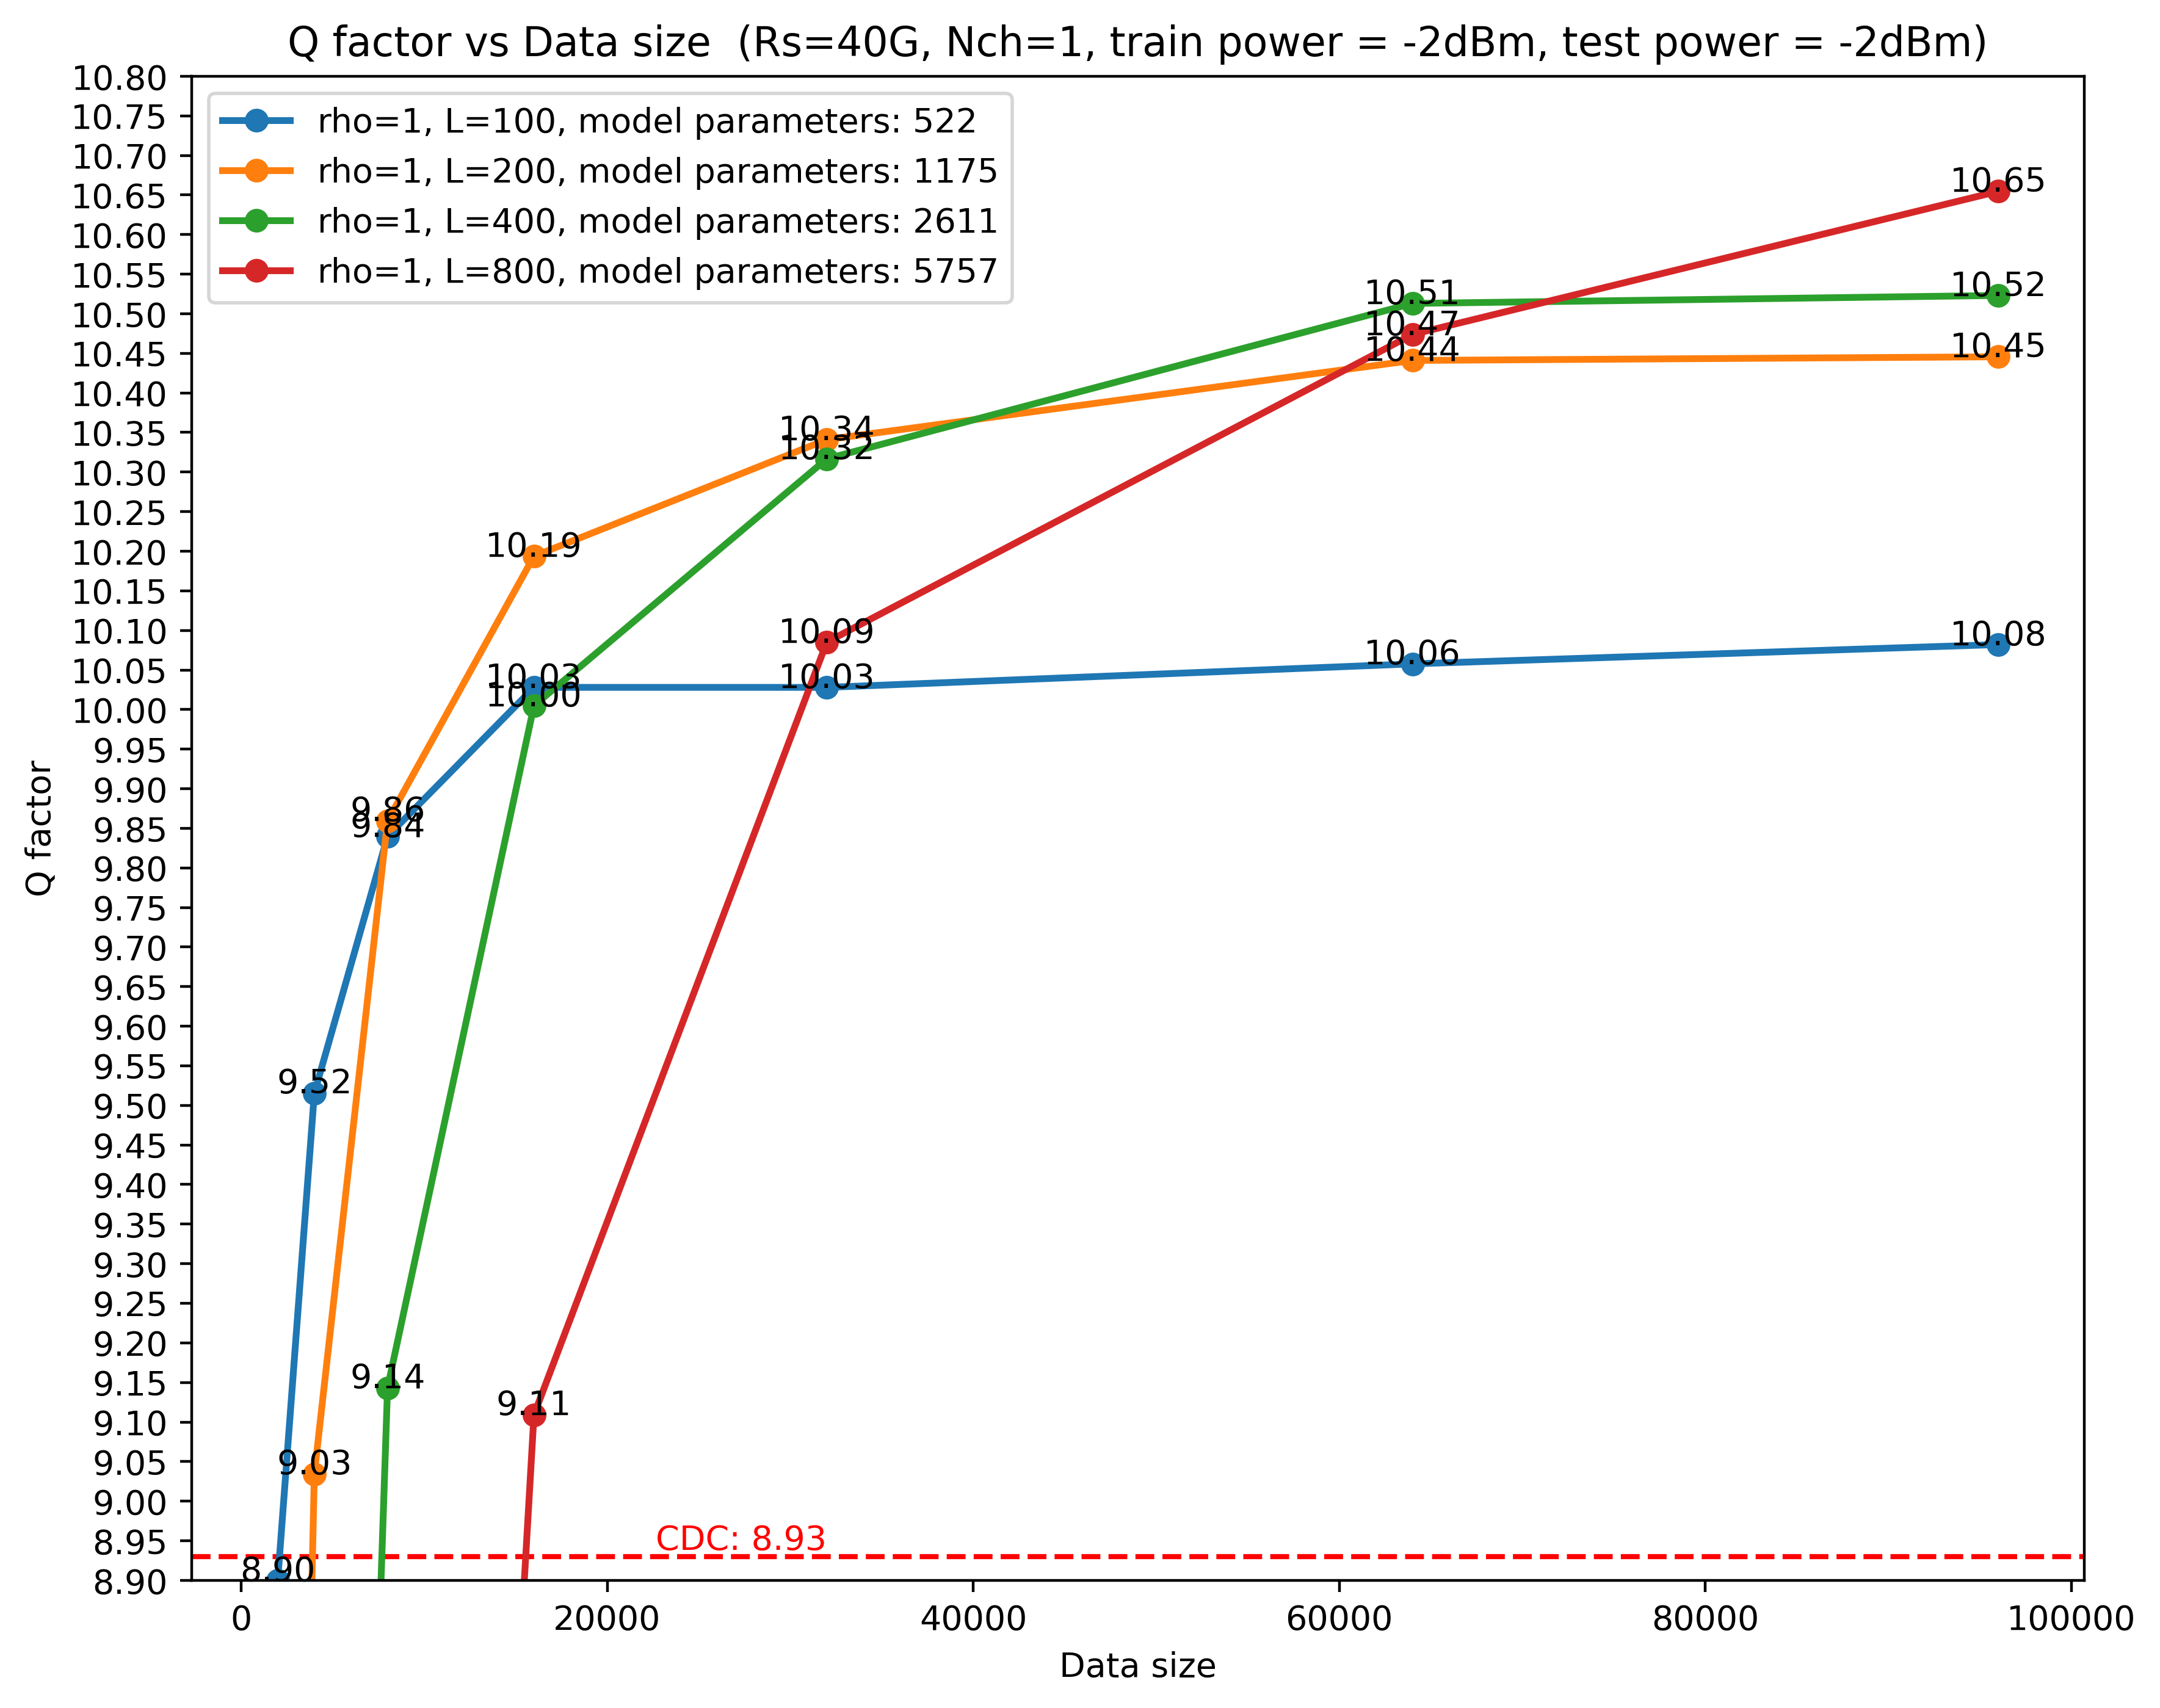

In [114]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls = [100, 200, 400, 800]

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[4], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'res_D_L_Tr-2_Te-2.pkl', 'rb'))
y_range = [8.9, 10.8]

for L in Ls:
    Qs = np.array([res[f'Q1 D={d} L={L}'] for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o',linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

# scaling law